In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm
import sys
import os
from PIL import Image
sys.path.extend(["..", "../backbone","../.."])
import torchvision.transforms as transforms
from transform import Transform
from dataloader import create_dataloader
from data import RetinaDataset
from metric import Metric
import shap
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
device = torch.device("cpu")
#device = torch.device("cuda:0")
model = torch.load('models/iecte1.pth', map_location=torch.device('cpu'))
model.to(device)
# print(device)

IECTe(
  (backbone1): DenseNet201(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=

In [2]:
df = pd.read_csv('../../../data/GT-main/set1/all.csv')
image_names = ["aria_a_13_2","im0151","js888","1592"]
idx = df[df['ID'].isin(image_names)].index.tolist()
print(idx)

[295, 1729, 1930, 2514]


In [3]:
filename1 = './shap/ARMD/all-iecte1.png'
filename2 = './shap/ARMD/all-iecte1-info.txt'

data_dir = '../../../../data/GT-main'
batch_size = 16
image_size = 384
num_labels = 21
num_workers = 4
thresholds = [0.5]*num_labels
phase= 'all'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
threshold = [0.5,  0.7,  0.83, 0.75, 0.89, 0.6,  0.14, 0.41, 0.9,  0.94, 0.51, 0.07, 0.92, 0.09, 0.59, 0.97, 0.32, 0.37, 0.98, 0.54, 0.43]
class_names = ["DR","NORMAL","MH","ODC","TSLN","ARMD","DN","MYA","BRVO","ODP","CRVO","CNV","RS","ODE","LS","CSR","HTR","ASR","CRS","OTHER","RB"]
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../../data/GT-main/./set1/test.csv


384
../../../../data/GT-main/./set1/all.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


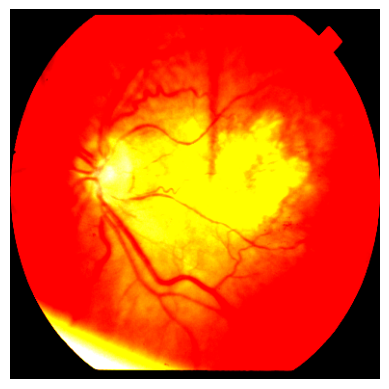

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


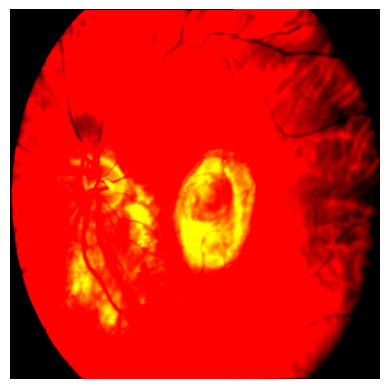

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


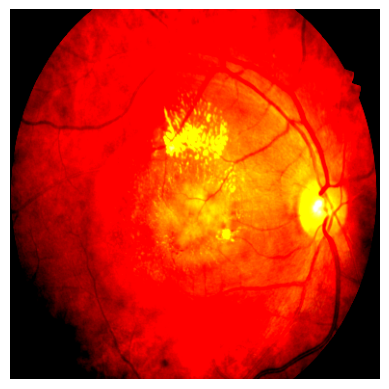

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


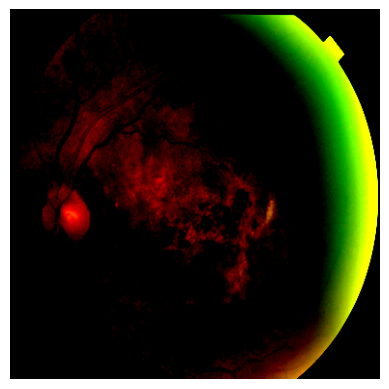

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
[[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
torch.Size([4, 21]) torch.Size([4, 384, 384, 3])


In [4]:
transform = Transform(size=image_size, phase=phase)
label_list = []
image_list = []
dataset = RetinaDataset(data_dir=data_dir, split=phase, transform=transform)
for i in idx:
    image = dataset[i][0]
    label = dataset[i][1]
    image_list.append(image.permute(1,2,0).unsqueeze(0))
    label_list.append(label.unsqueeze(0))
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()
    print(label)

images = torch.cat(image_list, dim=0)
labels = torch.cat(label_list, dim=0)
true_labels = labels.detach().cpu().numpy().astype(np.int32)
print(true_labels)
print(labels.shape, images.shape)

In [5]:
def predict(x):
    tmp = torch.tensor(x).to(device)
    tmp = tmp.permute(0,3,1,2)
    output = model(tmp)
    return torch.sigmoid(output)

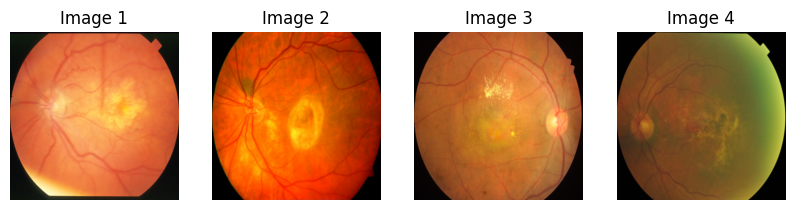

In [6]:
# Define the inverse transformation function
inv_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.permute(0, 3, 1, 2)),
    transforms.Normalize(mean=(-1 * np.array(mean) / np.array(std)).tolist(),std=(1 / np.array(std)).tolist(),),
    transforms.Lambda(lambda x: x.permute(0, 2, 3, 1)),
])

# Apply the inverse transformation to the transformed image tensor
original_images = inv_transform(images)
original_images = original_images.numpy()

# Plot the original images
plt.figure(figsize=(10, 5))
for i in range(original_images.shape[0]):
    plt.subplot(1, original_images.shape[0], i + 1)
    plt.imshow(original_images[i])
    plt.axis('off')
    plt.title(f'Image {i + 1}')
plt.show()

In [7]:
output = predict(images)
print(output)

thresholds = [0.5]*num_labels
outputs = output.detach().cpu().numpy()
outputs_thresholded = (outputs > thresholds).astype(np.int32)
print(outputs_thresholded)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[5.9177e-02, 3.3225e-03, 2.8642e-03, 5.5532e-03, 3.0012e-03, 1.8313e-01,
         2.2795e-03, 4.6255e-03, 1.7530e-03, 2.2369e-03, 2.8304e-02, 7.1874e-01,
         5.8360e-03, 3.7128e-03, 3.9807e-03, 8.6484e-04, 2.5079e-02, 4.5751e-03,
         2.7583e-03, 5.0801e-02, 3.8555e-03],
        [4.4942e-03, 4.8909e-02, 7.4689e-03, 4.1654e-03, 2.7952e-02, 8.2013e-01,
         3.4501e-03, 4.6553e-02, 3.7577e-04, 8.0667e-04, 3.4527e-03, 2.1274e-02,
         3.3352e-04, 3.3826e-03, 1.7337e-03, 7.4409e-02, 4.7933e-04, 4.8078e-03,
         4.0503e-02, 1.2060e-02, 9.1195e-04],
        [1.1934e-03, 2.1095e-03, 8.7203e-04, 1.5494e-03, 1.7148e-03, 7.3590e-01,
         1.4403e-03, 8.3779e-04, 2.7546e-03, 5.1453e-04, 1.2585e-04, 3.7437e-02,
         5.8918e-02, 2.4962e-03, 5.6192e-04, 8.3616e-02, 1.0426e-02, 3.8276e-04,
         6.3458e-03, 1.4537e-02, 2.4014e-03],
        [1.0867e-02, 3.4225e-03, 3.9089e-03, 3.2229e-03, 1.3540e-02, 9.5211e-01,
         2.2061e-03, 7.5127e-03, 3.6757e-03, 1.6633e

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix
acc_list, spec_list = [], []
labels_true = labels.detach().cpu().numpy().astype(np.int32)
for label_index in range(labels.shape[1]):
            label_true = labels_true[:, label_index]
            label_pred = outputs_thresholded[:, label_index]

            # Check if label_true and label_pred contain only one unique value
            if len(set(label_true)) == 1 and len(set(label_pred)) == 1:
                acc = accuracy_score(label_true, label_pred)
                spec = 0.0  # Set specificity to 0 when there's only one class present
            else:
                acc = accuracy_score(label_true, label_pred)
                tn, fp, _, _ = confusion_matrix(label_true, label_pred).ravel()
                spec = tn / (tn + fp) if (tn + fp) != 0 else 0.0

            acc_list.append(acc)
            spec_list.append(spec)

print(acc_list,"\n", spec_list)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [9]:
print(image.shape)

torch.Size([3, 384, 384])


In [10]:
# Initialize Shapley Explainer
masker = shap.maskers.Image("blur(64,64)", shape=images[0].shape)
explainer = shap.Explainer(predict, masker, output_names=class_names)

print("Type of explainer:", type(explainer))

shap_values = explainer(images, max_evals=10000, batch_size=50, outputs=shap.Explanation.argsort.flip[:2])
torch.cuda.empty_cache()

Type of explainer: <class 'shap.explainers._partition.PartitionExplainer'>


  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [4:35:21<1:08:13, 4093.82s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [6:51:47<00:00, 5799.18s/it]  

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [9:08:06, 8221.70s/it]                       


In [11]:
print(shap_values.data.shape, shap_values.values.shape)

torch.Size([4, 384, 384, 3]) (4, 384, 384, 3, 2)


In [12]:
# Assuming shap_values contains your SHAP values
shap_data = inv_transform(shap_values.data).cpu().numpy()
shap_val = [val for val in np.moveaxis(shap_values.values, -1, 0)]
print(shap_data, shap_val)

[[[[2.7450982e-02 5.3405760e-08 4.3137241e-02]
   [2.3529382e-02 5.3405760e-08 3.9215691e-02]
   [1.9607836e-02 3.9215852e-03 4.7058817e-02]
   ...
   [1.9607836e-02 5.3405760e-08 3.1372536e-02]
   [2.3529382e-02 5.3405760e-08 3.9215691e-02]
   [3.5294101e-02 3.9215852e-03 4.3137241e-02]]

  [[3.1372529e-02 1.1764728e-02 3.9215691e-02]
   [2.7450982e-02 3.9215852e-03 4.3137241e-02]
   [1.5686290e-02 7.8431703e-03 3.5294116e-02]
   ...
   [2.3529382e-02 5.3405760e-08 3.1372536e-02]
   [1.1764691e-02 5.3405760e-08 3.9215691e-02]
   [2.3529382e-02 5.3405760e-08 4.7058817e-02]]

  [[3.1372529e-02 7.8431703e-03 3.5294116e-02]
   [2.7450982e-02 5.3405760e-08 3.5294116e-02]
   [1.9607836e-02 5.3405760e-08 3.5294116e-02]
   ...
   [3.1372529e-02 5.3405760e-08 3.9215691e-02]
   [2.7450982e-02 5.3405760e-08 3.9215691e-02]
   [2.3529382e-02 5.3405760e-08 4.3137241e-02]]

  ...

  [[4.7058821e-02 7.0588261e-02 4.7058817e-02]
   [4.7058821e-02 7.4509822e-02 4.7058817e-02]
   [5.0980393e-02 6.666670

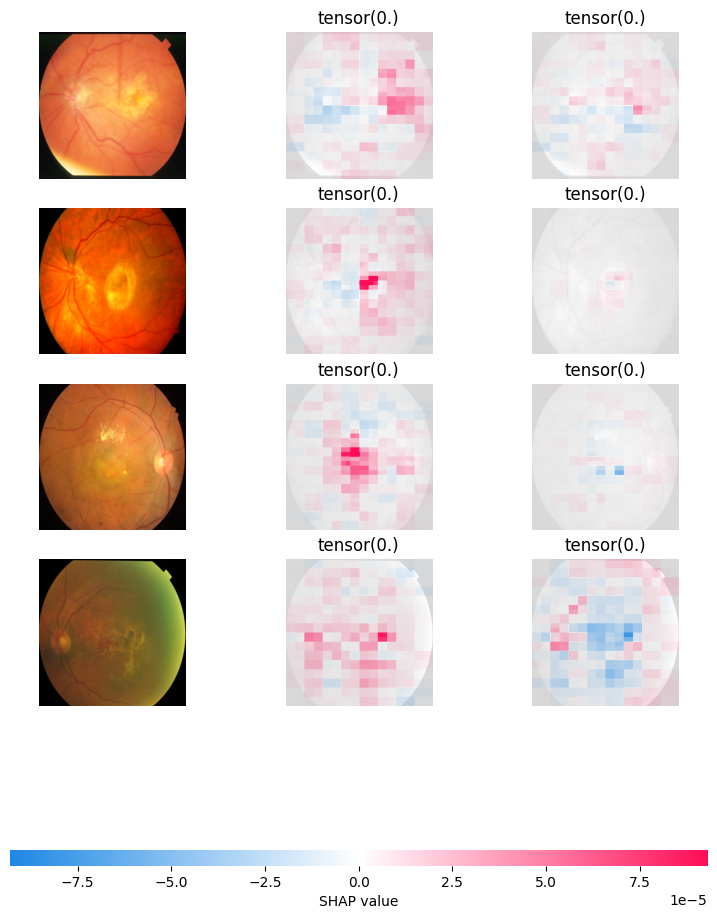

Image No. 295, Image name aria_a_13_2:
Top Predictions: 0.7187, 0.1831, 0.0592, 0.0508
Top Class IDs: [11  5  0 19]
Top Class Names: ['CNV', 'ARMD', 'DR', 'OTHER']
Predicted Classes: ['CNV']
True Classes: ['ARMD', 'CNV']

Image No. 1729, Image name im0151:
Top Predictions: 0.8201, 0.0744, 0.0489, 0.0466
Top Class IDs: [ 5 15  1  7]
Top Class Names: ['ARMD', 'CSR', 'NORMAL', 'MYA']
Predicted Classes: ['ARMD']
True Classes: ['ARMD']

Image No. 1930, Image name js888:
Top Predictions: 0.7359, 0.0836, 0.0589, 0.0374
Top Class IDs: [ 5 15 12 11]
Top Class Names: ['ARMD', 'CSR', 'RS', 'CNV']
Predicted Classes: ['ARMD']
True Classes: ['ARMD']

Image No. 2514, Image name 1592:
Top Predictions: 0.9521, 0.0558, 0.0380, 0.0135
Top Class IDs: [ 5 19 11  4]
Top Class Names: ['ARMD', 'OTHER', 'CNV', 'TSLN']
Predicted Classes: ['ARMD']
True Classes: ['ARMD']



In [35]:
def save_shap_image(shap_values, shap_data, labels, filename):
    shap.image_plot(shap_values=shap_values,pixel_values=shap_data,labels=labels,show=False)
    plt.show()

save_shap_image(shap_val, shap_data, labels = shap_values.output_names, filename = filename1)

with open(filename2, 'w') as f:
    for i in range(len(idx)):
        sorted_output = torch.sort(output[i], descending=True)
        top_preds = np.array(sorted_output[0][:4].detach().cpu().numpy()) 
        top_indices = sorted_output[1][:4].cpu().numpy()
        formatted_preds = ', '.join([f'{pred:.4f}' for pred in top_preds])
        pred_classes = top_preds > 0.5
        top_classes = np.where(labels[i] == 1)[0]

        print(f'Image No. {idx[i]}, Image name {image_names[i]}:\nTop Predictions: {formatted_preds}\nTop Class IDs: {top_indices}'
            f'\nTop Class Names: {[class_names[idx] for idx in top_indices]}\nPredicted Classes: {[class_names[idx] for idx in top_indices[pred_classes]]}'
            f'\nTrue Classes: {[class_names[idx] for idx in top_classes]}\n')

        f.write(f'Image No. {idx[i]}:\n')
        f.write(f'Image names {image_names[i]}:\n')
        f.write(f'Top Predictions: {formatted_preds}\n')
        f.write(f'Top Class IDs: {top_indices}\n')
        f.write(f'Top Class Names: {[class_names[idx] for idx in top_indices]}\n')
        f.write(f'Predicted Classes: {[class_names[idx] for idx in top_indices[pred_classes]]}\n')
        f.write(f'True Classes: {[class_names[idx] for idx in top_classes]}\n\n')

    f.write('Thresholds:\n')
    f.write('\n'.join(map(str, threshold)) + '\n')
    
    f.write('\nClass Names:\n')
    f.write('\n'.join(class_names) + '\n')